# **Association between Abstract Characteristics and Ranking Position in Technology-Assisted Reviewing (TAR): coding set-up**

### **by Isa Spiero <br>**

#### **Part I: Data**

In Part I, the datasets are imported. These are the datasets from the previously conducted systematic reviews by Andaur Navarro *et al.* (2022) and Heus *et al.* (2018), respectively. For each review, the titles and abstracts of the records along with the title-abstract level inclusions, full-text level inclusions, and abstract characteristics are present in the dataset. The abstract characterstics consist of: (I) abstract reporting quality as defined by TRIPOD scores, (II) abstract structural components, and (III) abstract language usage.

#### **Part II: Ranking** 

A screening tool (ASReview) was used to simulate the title-abstract screening by using active learning to rank and prioritize records that are most likely to be relevant for the review. These ranking algorithms use a feature extractor and classifier to compute rankings. The simulations were continued until all records have passed, and the final rankings were saved and are merged with the datasets.

#### **Part III: Evaluation**

In the evaluation, the association between abstract characteristics (as described under *Data*) and the ranking position (as computed with the tool under *Ranking*) is examined, divided into (I) abstract TRIPOD adherence, (II) abstract structure, and (III) abstract terminology usage.

------------------------------------------------------------------------------------------------------------------------------------------

In [1]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from pathlib import Path
from scipy.stats import spearmanr, mannwhitneyu

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

#### **Part I: Data**
Load the data that were preprocessed with the data_preprocessing.ipynb notebook:

In [2]:
path_output = "./output/output/simulations_original_datasets/"
path_data = "./data/processed/"

In [3]:
review_dic = {}

for file_name in os.listdir(path_data):
    if file_name.endswith('.csv'):
        file_path = os.path.join(path_data, file_name)
        df = pd.read_csv(file_path)
        key = os.path.splitext(file_name)[0].split("_")[0]
        review_dic[key] = df

review_dic = dict(sorted(review_dic.items()))

In [4]:
for key, df in review_dic.items():
    df.rename(columns={'Unnamed: 0': 'record_id'}, inplace=True)

#### **Part II: Ranking**

Load rankings of previous study

In [5]:
# Specify the the classification, feature extraction, and query model(s) that were tested
train_models = ['logistic'] 
feature_models = ['tfidf', 'sbert', 'doc2vec']
query_models = ['max']

# Specify the number of simulations per review-model combination  
n_simulations = 200 

In [6]:
# Create a list of the review-model combination names
sim_list_names = []
for review in review_dic:
    for train_model in train_models:
        for feature_model in feature_models:
            for query_model in query_models:
                review_id = str(review + "_" + train_model + "_" + feature_model + "_" + query_model )
                sim_list_names.append(review_id)
             
# Retrieve the output from the HPC generated pickle files with each having the rankings of a single simulation
multiple_sims = []
for i in range(0, len(sim_list_names)):
    raw_output = {}
    for j in range(1,n_simulations+1):
        if Path(path_output +'sim_{review_id}_{sim}.p'.format(review_id=sim_list_names[i], sim=j)).is_file():
            with open(path_output + 'sim_{review_id}_{sim}.p'.format(review_id=sim_list_names[i], sim=j),'rb') as f:
                raw_output.update(pickle.load(f))
    if len(raw_output) > 0:
        multiple_sims.append((sim_list_names[i], len(review_dic[sim_list_names[i].split('_')[0]]), n_simulations, raw_output))

Merge the rankings with the datasets

In [7]:
warnings.filterwarnings('ignore', category=FutureWarning)

review_dic_merged = review_dic.copy()

for i in review_dic:
    for j in range(0, len(multiple_sims)):
        if multiple_sims[j][0].split('_')[0] == i:

            for k in multiple_sims[j][3]:          

                review_sim = multiple_sims[j][0] + "_" + str(j)
                review_key = multiple_sims[j][0].split('_')[0]
                index_list = multiple_sims[j][3][k][0]['record_id']
                review_dic_merged[review_key][review_sim] = review_dic_merged[review_key]['record_id'].map({val: idx for idx, val in enumerate(index_list)})
            
    review_dic_merged[review_key]['ranking_average_logistic_tfidf'] = review_dic_merged[review_key].filter(like='logistic_tfidf').mean(axis=1)
    review_dic_merged[review_key]['ranking_average_logistic_sbert'] = review_dic_merged[review_key].filter(like='logistic_sbert').mean(axis=1)
    review_dic_merged[review_key]['ranking_average_logistic_doc2vec'] = review_dic_merged[review_key].filter(like='logistic_doc2vec').mean(axis=1)

#### **Part III: Evaluation**

In [8]:
characteristics = ['1i', '1ii', '1iii', '1iv',
                   '2i', '2ii', '2iii', '2iv', '2v',
                   '2vi', '2vii', '2viii', '2ix', '2x',
                   '2xi', '2xii',
                   'percentage_reported',
                   'word_count', 'avg_sentence_length', 'structured',
                   'tfidf_deviation'
                  ]
review = ['Prog1', 'Prog3'
         ]
rankings = ['ranking_average_logistic_tfidf', 
            'ranking_average_logistic_sbert',
            'ranking_average_logistic_doc2vec'
           ]

In [9]:
results = []

# Loop through each review
for review_name in review:
    df = review_dic_merged[review_name]  
    
    # Loop through each characteristic
    for characteristic in characteristics:
        
        # Check if the characteristic is binary (only 2 unique values)
        is_binary = df[characteristic].nunique() == 2
        
        # Loop through each ranking
        for ranking in rankings:
            # Drop NaN values
            df_clean = df[[characteristic, ranking]].dropna()
            
            # Standardize 'tfidf_deviation' if it's the current characteristic
            if characteristic == 'tfidf_deviation':
                df_clean['standardized_tfidf_deviation'] = (df_clean[characteristic] - df_clean[characteristic].mean()) / df_clean[characteristic].std()
            
            if len(df_clean) > 1:  
                result_dict = {
                    'Review': review_name,
                    'Characteristic': characteristic,
                    'Ranking method': ranking,
                    'Correlation type': 'Binary' if is_binary else 'Continuous',
                    'Correlation coefficient': None,
                    'p-value': None,
                    'Beta': None,
                    'R-squared': None
                }
                
                if is_binary:
                    # Compute Rank-Biserial correlation using Mann-Whitney U test
                    group1 = df_clean[df_clean[characteristic] == 0][ranking]
                    group2 = df_clean[df_clean[characteristic] == 1][ranking]
                    
                    if len(group1) > 0 and len(group2) > 0:
                        U, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
                        n1, n2 = len(group1), len(group2)
                        rank_biserial_corr = 1 - (2 * U / (n1 * n2))  # Convert U to Rank-Biserial correlation

                        result_dict['Correlation coefficient'] = rank_biserial_corr
                        result_dict['p-value'] = p_value
                
                else:
                    # Use standardized 'tfidf_deviation' in regression if it's a continuous variable
                    if characteristic == 'tfidf_deviation':
                        X = sm.add_constant(df_clean['standardized_tfidf_deviation'])  # Add intercept
                    else:
                        X = sm.add_constant(df_clean[characteristic])  # Add intercept
                    
                    model = sm.OLS(df_clean[ranking], X).fit()
                    
                    result_dict['Correlation coefficient'] = spearmanr(df_clean[characteristic], df_clean[ranking])[0]
                    result_dict['p-value'] = spearmanr(df_clean[characteristic], df_clean[ranking])[1]
                    result_dict['Beta'] = model.params[1] 
                    result_dict['R-squared'] = model.rsquared
                
                results.append(result_dict)

# Convert results to DataFrame
correlation_df = pd.DataFrame(results)
correlation_df = correlation_df.applymap(lambda x: round(x, 3) if isinstance(x, (int, float)) else x)

correlation_df

,Review,Characteristic,Ranking method,Correlation type,Correlation coefficient,p-value,Beta,R-squared
0,Prog1,1i,ranking_average_logistic_tfidf,Binary,-0.096,0.520,NaN,NaN
1,Prog1,1i,ranking_average_logistic_sbert,Binary,-0.114,0.447,NaN,NaN
2,Prog1,1i,ranking_average_logistic_doc2vec,Binary,-0.127,0.397,NaN,NaN
3,Prog1,1ii,ranking_average_logistic_tfidf,Binary,-0.434,0.000,NaN,NaN
4,Prog1,1ii,ranking_average_logistic_sbert,Binary,-0.492,0.000,NaN,NaN
...,...,...,...,...,...,...,...,...
121,Prog3,structured,ranking_average_logistic_sbert,Binary,-0.212,0.000,NaN,NaN
122,Prog3,structured,ranking_average_logistic_doc2vec,Binary,-0.218,0.000,NaN,NaN
123,Prog3,tfidf_deviation,ranking_average_logistic_tfidf,Continuous,0.009,0.913,13.314,0.001
124,Prog3,tfidf_deviation,ranking_average_logistic_sbert,Continuous,0.002,0.978,9.506,0.000


Clean the dataframe for publication

In [10]:
correlation_df['Review'] = correlation_df['Review'].replace({'Prog1': 'Review 1', 
                                                             'Prog3': 'Review 2'})
correlation_df['Characteristic'] = correlation_df['Characteristic'].replace({'percentage_reported': 'Percentage of TRIPOD criteria reported', 
                                                                             'word_count': 'Number of words in abstract',
                                                                             'avg_sentence_length':'Average number of words per sentence',
                                                                             'structured': 'Structured vs unstructured abstracts',
                                                                             'tfidf_deviation': 'Abstract terminology usage (TF-IDF deviation)'})

correlation_df['Ranking method'] = correlation_df['Ranking method'].replace({'ranking_average_logistic_tfidf': 'TF-IDF', 
                                                                             'ranking_average_logistic_sbert': 'sBERT',
                                                                             'ranking_average_logistic_doc2vec': 'Doc2Vec'})
correlation_df_final = correlation_df.drop(columns=['Beta'])

correlation_df_final.to_excel('./output/results/coefs_table.xlsx', index=False)  

correlation_df_final

,Review,Characteristic,Ranking method,Correlation type,Correlation coefficient,p-value,R-squared
0,Review 1,1i,TF-IDF,Binary,-0.096,0.520,NaN
1,Review 1,1i,sBERT,Binary,-0.114,0.447,NaN
2,Review 1,1i,Doc2Vec,Binary,-0.127,0.397,NaN
3,Review 1,1ii,TF-IDF,Binary,-0.434,0.000,NaN
4,Review 1,1ii,sBERT,Binary,-0.492,0.000,NaN
...,...,...,...,...,...,...,...
121,Review 2,Structured vs unstructured abstracts,sBERT,Binary,-0.212,0.000,NaN
122,Review 2,Structured vs unstructured abstracts,Doc2Vec,Binary,-0.218,0.000,NaN
123,Review 2,Abstract terminology usage (TF-IDF deviation),TF-IDF,Continuous,0.009,0.913,0.001
124,Review 2,Abstract terminology usage (TF-IDF deviation),sBERT,Continuous,0.002,0.978,0.000


In [11]:
# Also rename the review for the rest of the results of the current study
rename_map = {'Prog1': 'Review 1', 'Prog3': 'Review 2'}
review_dic_merged = {rename_map.get(k, k): v for k, v in review_dic_merged.items()}

for key, value in review_dic_merged.items():
    review_dic_merged[key] = review_dic_merged[key].rename(columns={'ranking_average_logistic_tfidf': 'TF-IDF', 
                                                                    'ranking_average_logistic_sbert': 'sBERT',
                                                                    'ranking_average_logistic_doc2vec': 'Doc2Vec'})

To visually explore if the rankings differ in recall between the different feature extraction models:

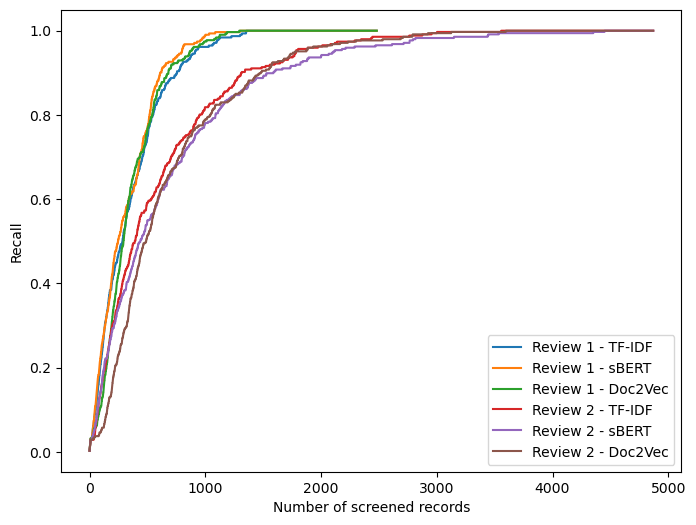

In [12]:
rankings = ['TF-IDF', 
            'sBERT', 
            'Doc2Vec'
                  ]
dfs = ['Review 1', 'Review 2']

plt.figure(figsize=(8, 6)) 

for df_name in dfs:
    df = review_dic_merged[df_name]
    for ranking in rankings:
        
        df_sort = df.sort_values(by=ranking, ascending=True) 
        
        labels = df_sort['label_ta_included']
        labels_series = pd.Series(labels)
        total_ones = labels_series.sum()
        cumulative_sum = labels_series.cumsum()
        proportion_ones = cumulative_sum / total_ones
    
        plt.plot(range(0, len(df)), proportion_ones, label=f'{df_name} - {ranking}')

plt.xlabel("Number of screened records")
plt.ylabel("Recall")
plt.legend()  
plt.show() 

**(a) Abstract TRIPOD adherence**

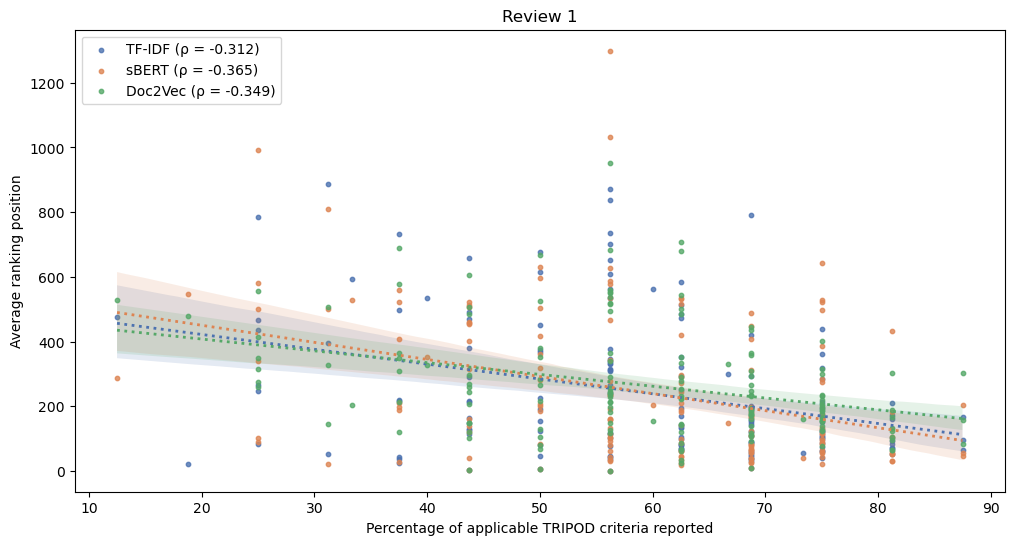

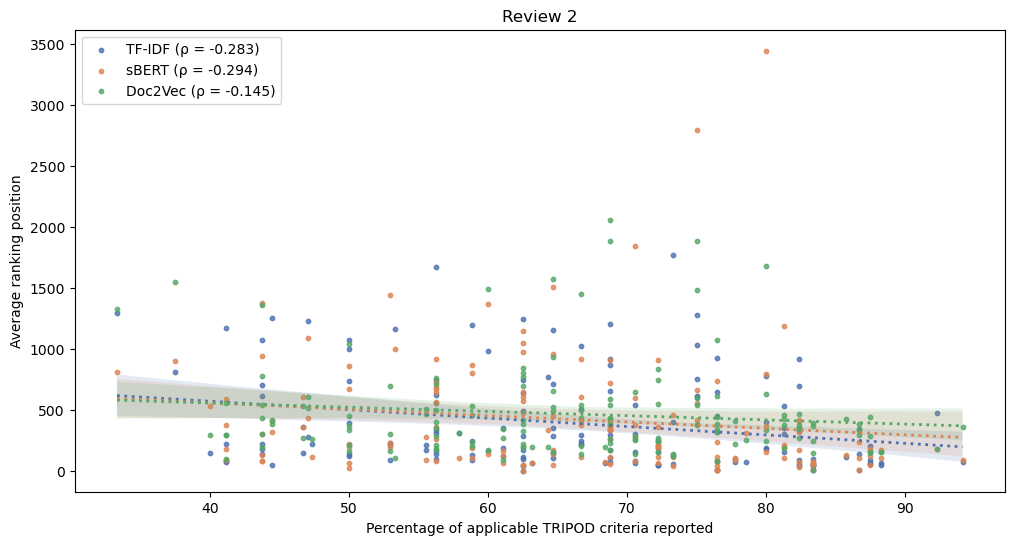

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

dfs = ['Review 1', 'Review 2'] 

for df_name in dfs: 
    df = review_dic_merged[df_name]
    df_plot1 = df[df['label_ft_included'] == 1].copy()
    
    x_variables = ['percentage_reported']
    y_variables = ['TF-IDF', 'sBERT', 'Doc2Vec']
    
    plt.figure(figsize=(12, 6))
    
    colors = sns.color_palette("deep", len(y_variables))
    
    for i, y_var in enumerate(y_variables):
        x = df['percentage_reported']
        y = df[y_var]

        # Drop NaN values for accurate correlation computation
        df_clean = df_plot1[[x_variables[0], y_var]].dropna()
        spearman_corr, _ = spearmanr(df_clean[x_variables[0]], df_clean[y_var])

        sns.regplot(
            x=x, y=y, scatter=True, 
            scatter_kws={"s": 10, "color": colors[i]},
            line_kws={"linewidth": 2, "linestyle": "dotted", "color": colors[i]},
            label=f"{y_var} (ρ = {spearman_corr:.3f})"
        )  
    
    plt.ylabel("Average ranking position")
    plt.xlabel("Percentage of applicable TRIPOD criteria reported")
    plt.legend(loc='upper left', frameon=True)
    plt.title(f'{df_name}')
    plt.show()


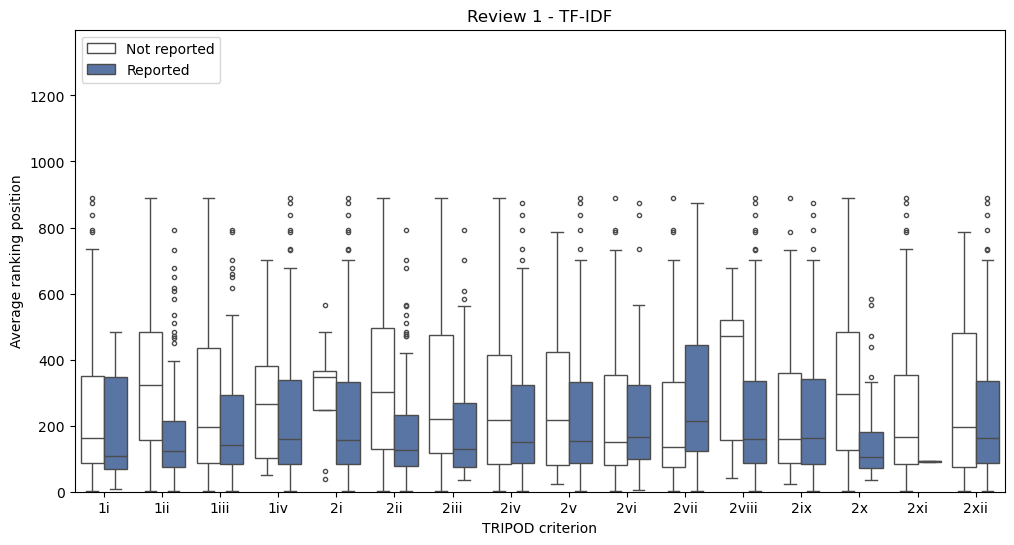

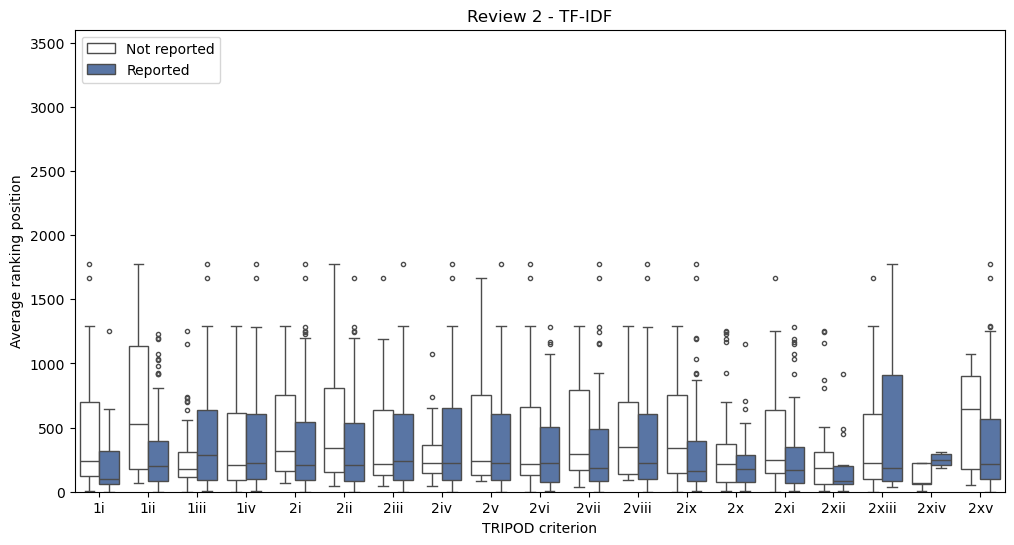

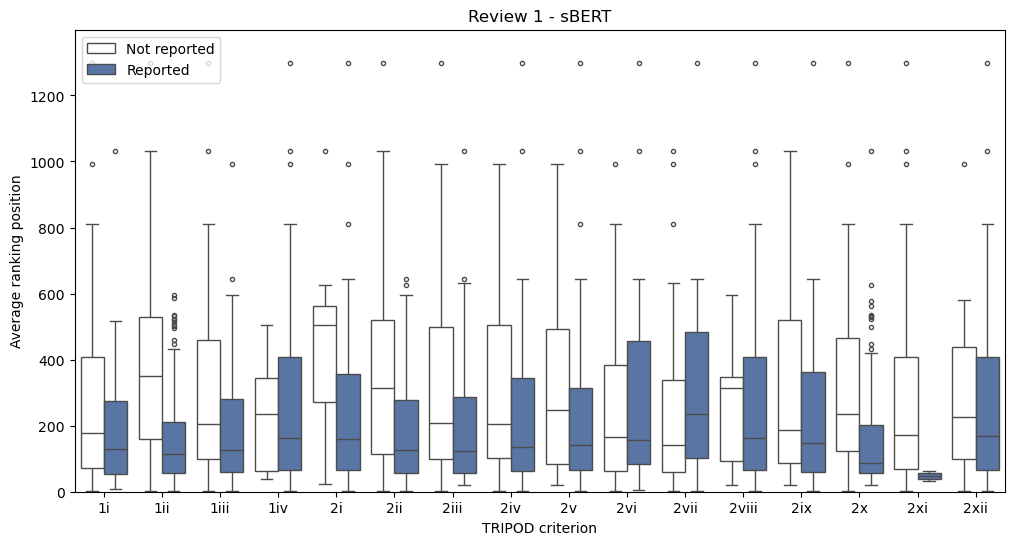

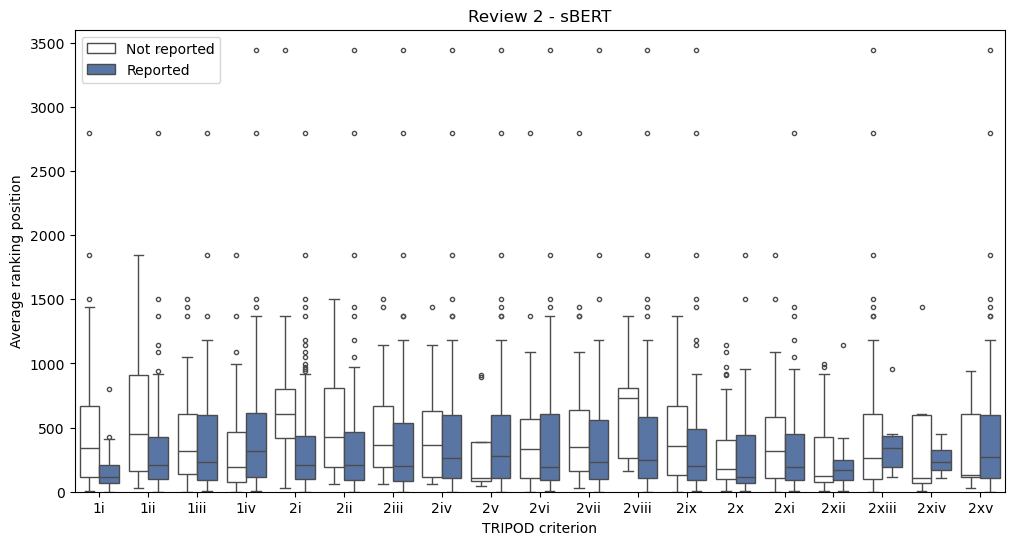

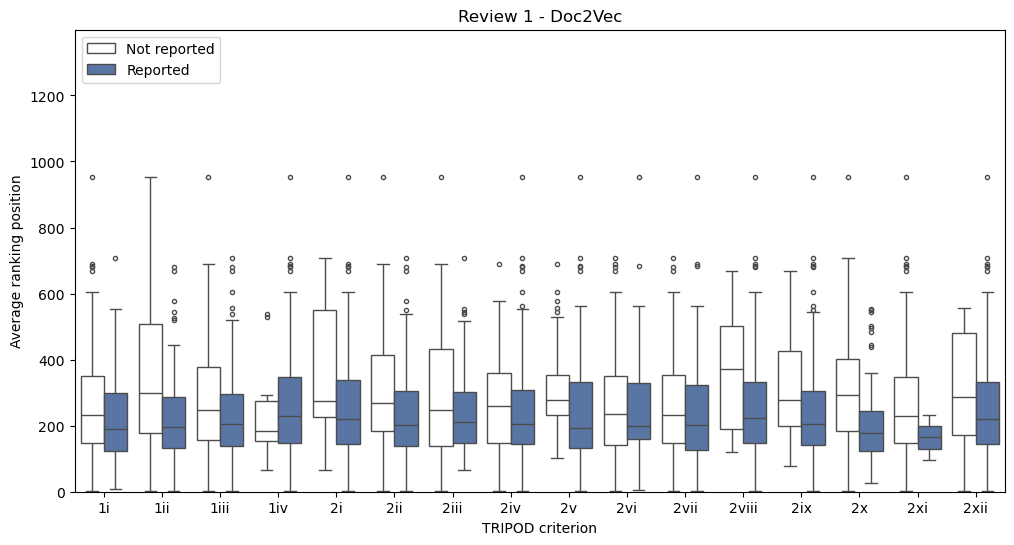

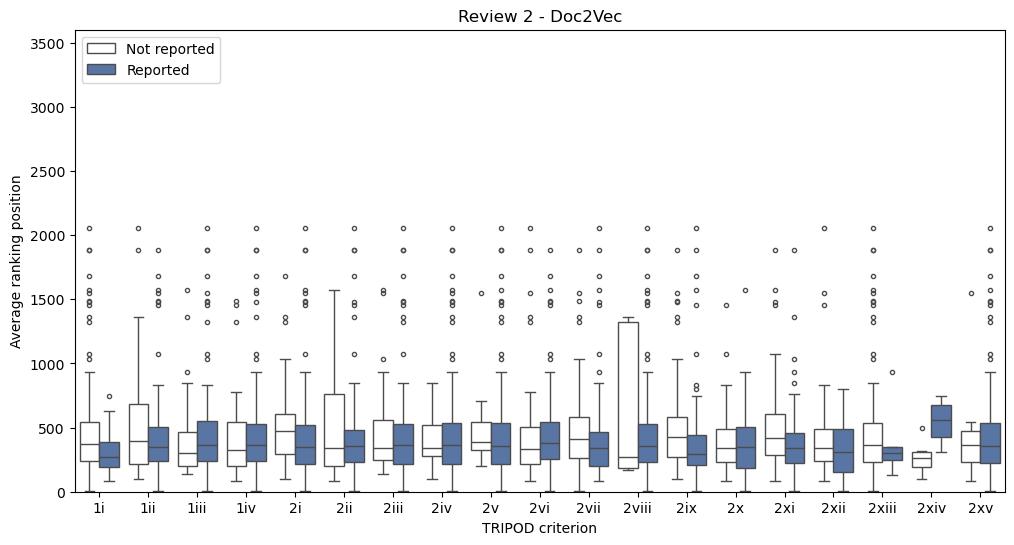

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

rankings = ['TF-IDF', 
            'sBERT', 
            'Doc2Vec'
            ]

for ranking in rankings:
    
    for df_name in dfs:
    
        df_plot2 = review_dic_merged[df_name].copy()
        
        # Select 'ranking_average_logistic_tfidf' and columns that start with '1' or '2'
        selected_columns = [ranking] + list(df_plot2.filter(regex='^(1|2)'))
        
        # Select those columns
        df_selected = df_plot2[selected_columns]
        
        # Reshape from wide to long format
        df_melted = df_selected.melt(id_vars=ranking, var_name='item', value_name='value')
        
        # Convert the ranking to numeric values for plotting
        df_melted[ranking] = pd.to_numeric(df_melted[ranking])
        
        # Create the boxplot
        custom_palette = {0: "white", 1: sns.color_palette("deep")[0]} 
        
        plt.figure(figsize=(12, 6))
        sns.boxplot(x="item", y=ranking, hue="value", data=df_melted,
                    palette=custom_palette,
                    flierprops={"marker": "o", "markersize": 3})
        if df_name == 'Review 1':
            plt.ylim(0, 1399)
        if df_name == 'Review 2':
            plt.ylim(0, 3600)
        
        # Customize the labels
        plt.ylabel("Average ranking position")
        plt.xlabel("TRIPOD criterion")
        
        # Add the legend
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(loc='upper left', frameon=True,
            handles=handles, 
            labels=['Not reported', 'Reported']
        )
        plt.title(f'{df_name} - {ranking}')
        
        plt.show()

In [15]:
sorted_prog3 = review_dic_merged['Review 2'].sort_values(by='sBERT', ascending=False)
print('outlier 1: \n\n', sorted_prog3['abstract'][0])
print('\noutlier 2: \n\n', sorted_prog3['abstract'][1])

outlier 1: 

 OBJECTIVES: Among antiretroviral therapy (ART)-naive individuals, viral load levels tend to increase and CD4 cell counts decline over time. We sought to explore the rate of change and influence of other factors associated with these markers of HIV progression. DESIGN: An observational cohort collaboration study. METHODS: A total of 158 385 pairs of consecutive viral load and CD4 cell count simultaneously measured from 34 384 ART-naive individuals in the COHERE database were analysed. Annual changes and factors associated with these changes were estimated using generalized estimating equations. RESULTS: Viral load continued to rise at a mean [95% confidence interval (CI)] rate of 0.091 (0.086-0.096) log10 copies/ml per year. A faster rise in viral load was significantly associated with older age, such that for every 10 years older, it was a mean 0.022 log10 copies/ml per year greater. The mean (95% CI) CD4 cell count change was -78.0 (-80.1 to -76.0) cell/mul per year and 

**(b) Abstract structure** 

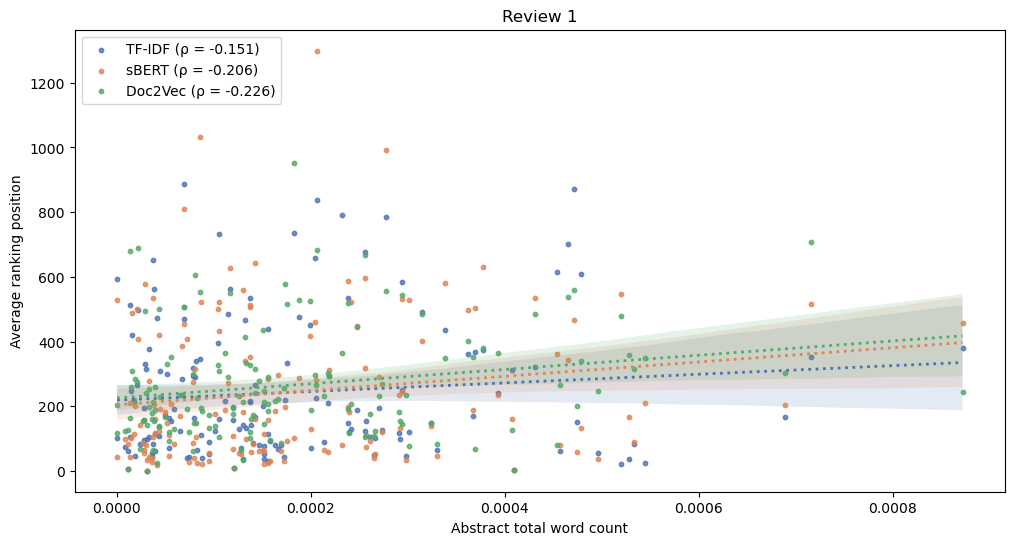

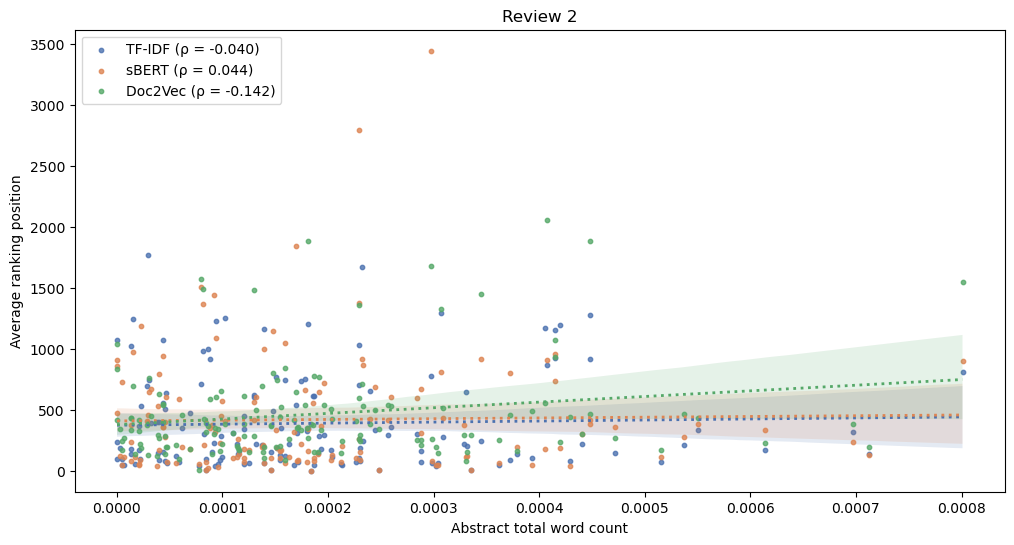

In [20]:
dfs = ['Review 1', 'Review 2'] 

for df_name in dfs: 
    df = review_dic_merged[df_name]
    df_plot1 = df[df['label_ft_included'] == 1].copy()
    
    x_variables = ['word_count']
    y_variables = ['TF-IDF', 
                   'sBERT', 
                   'Doc2Vec'
                  ]
    
    plt.figure(figsize=(12, 6))
    
    colors = sns.color_palette("deep", len(y_variables))
    
    for i, y_var in enumerate(y_variables):
        x = df_plot1[x_variable]
        y = df_plot1[y_var]

        # Drop NaN values for accurate correlation computation
        df_clean = df_plot1[[x_variables[0], y_var]].dropna()
        spearman_corr, _ = spearmanr(df_clean[x_variables[0]], df_clean[y_var])
        
        sns.regplot(x=x, y=y, scatter=True, 
                    scatter_kws={"s": 10, "color": colors[i]},
                    line_kws={"linewidth": 2, "linestyle": "dotted", "color": colors[i]},
                    label=f"{y_var} (ρ = {spearman_corr:.3f})")  
    
    plt.ylabel("Average ranking position")
    plt.xlabel("Abstract total word count")
    plt.legend(loc='upper left', frameon=True)
    plt.title(f'{df_name}')
    plt.show() 

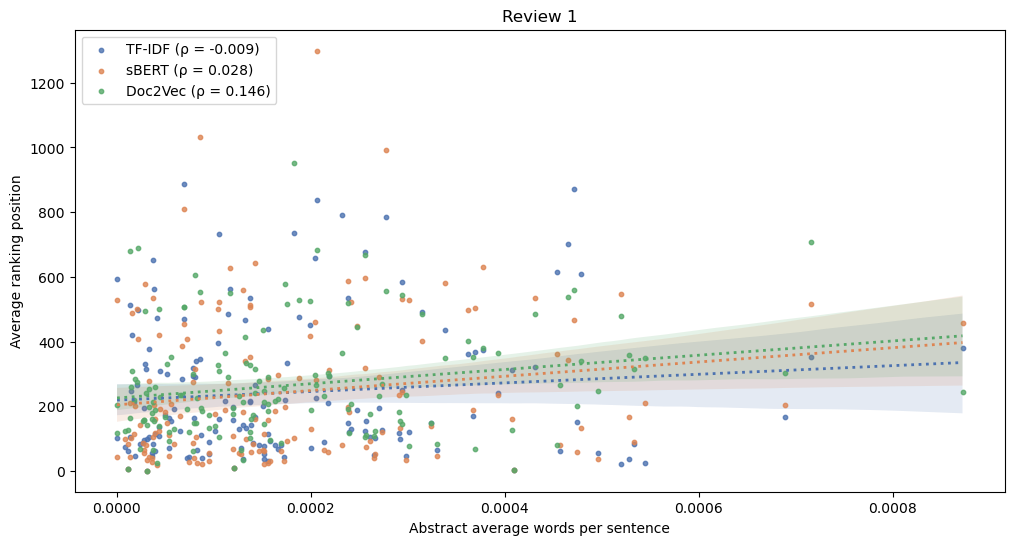

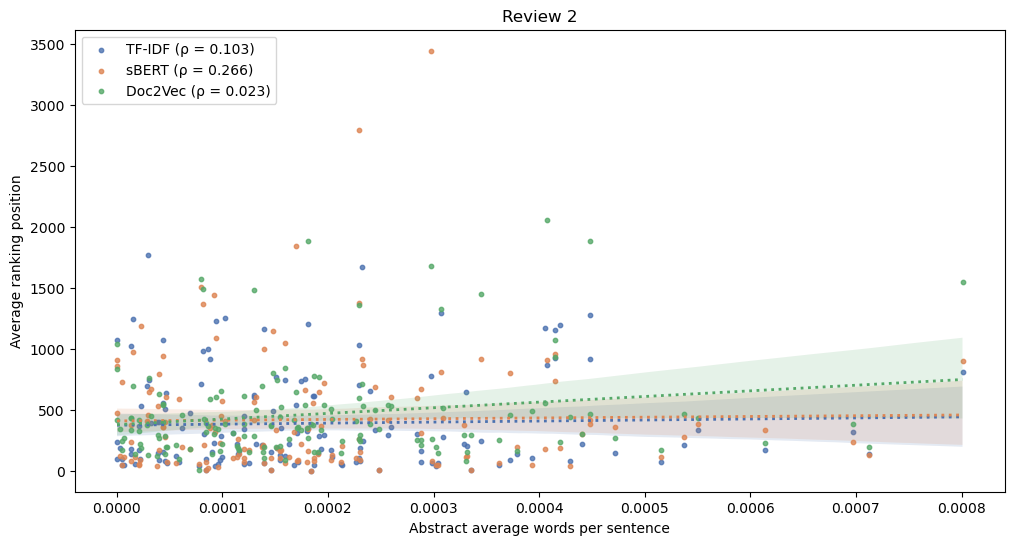

In [21]:
dfs = ['Review 1', 'Review 2'] 

for df_name in dfs: 
    df = review_dic_merged[df_name]
    df_plot1 = df[df['label_ft_included'] == 1].copy()
    
    x_variables = ['avg_sentence_length']
    y_variables = ['TF-IDF', 
                   'sBERT', 
                   'Doc2Vec'
                  ]
    
    plt.figure(figsize=(12, 6))
    
    colors = sns.color_palette("deep", len(y_variables))
    
    for i, y_var in enumerate(y_variables):
        x = df_plot1[x_variable]
        y = df_plot1[y_var]

        # Drop NaN values for accurate correlation computation
        df_clean = df_plot1[[x_variables[0], y_var]].dropna()
        spearman_corr, _ = spearmanr(df_clean[x_variables[0]], df_clean[y_var])

        
        sns.regplot(x=x, y=y, scatter=True, 
                    scatter_kws={"s": 10, "color": colors[i]},
                    line_kws={"linewidth": 2, "linestyle": "dotted", "color": colors[i]},
                    label=f"{y_var} (ρ = {spearman_corr:.3f})")  
    
    plt.ylabel("Average ranking position")
    plt.xlabel("Abstract average words per sentence")
    plt.legend(loc='upper left', frameon=True)
    plt.title(f'{df_name}')
    plt.show() 

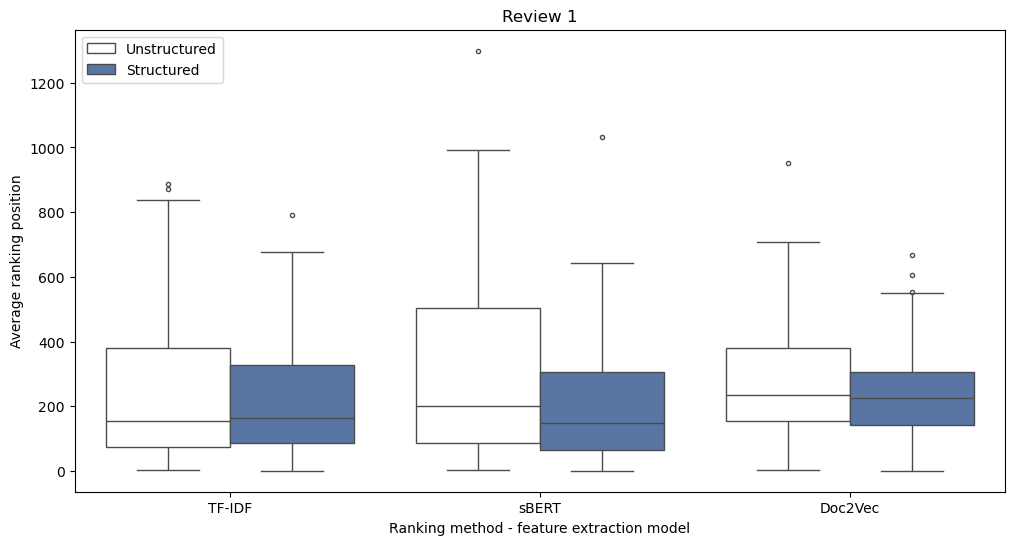

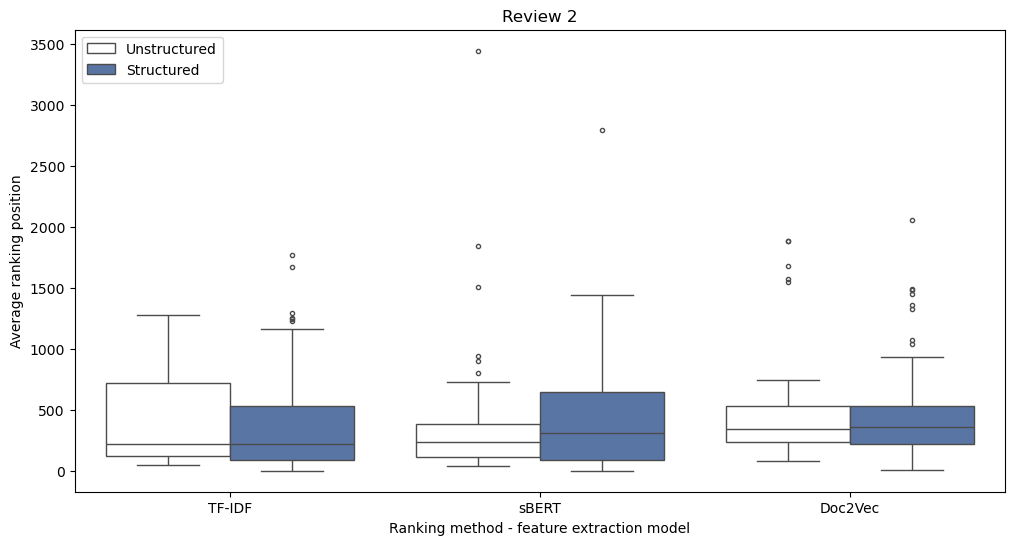

In [18]:
dfs = ['Review 1', 'Review 2'] 

rankings = ['TF-IDF', 
            'sBERT', 
            'Doc2Vec'
            ]

for df_name in dfs: 
    df = review_dic_merged[df_name]
    df_plot1 = df[df['label_ft_included'] == 1].copy()
    
    df_plot1 = pd.melt(df_plot1, id_vars=['structured'], value_vars=rankings,
                       var_name='Ranking', value_name='value')

    custom_palette = {0: "white", 1: sns.color_palette("deep")[0]} 
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Ranking', y='value', hue='structured', data=df_plot1,
                palette=custom_palette,
                flierprops={"marker": "o", "markersize": 3})

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(loc='upper left', frameon=True,
        handles=handles, 
        labels=['Unstructured', 'Structured']
    )
    
    plt.ylabel("Average ranking position")
    plt.xlabel("Ranking method - feature extraction model")
    plt.title(f'{df_name}')
    plt.show()

**(c) Abstract terminology usage**

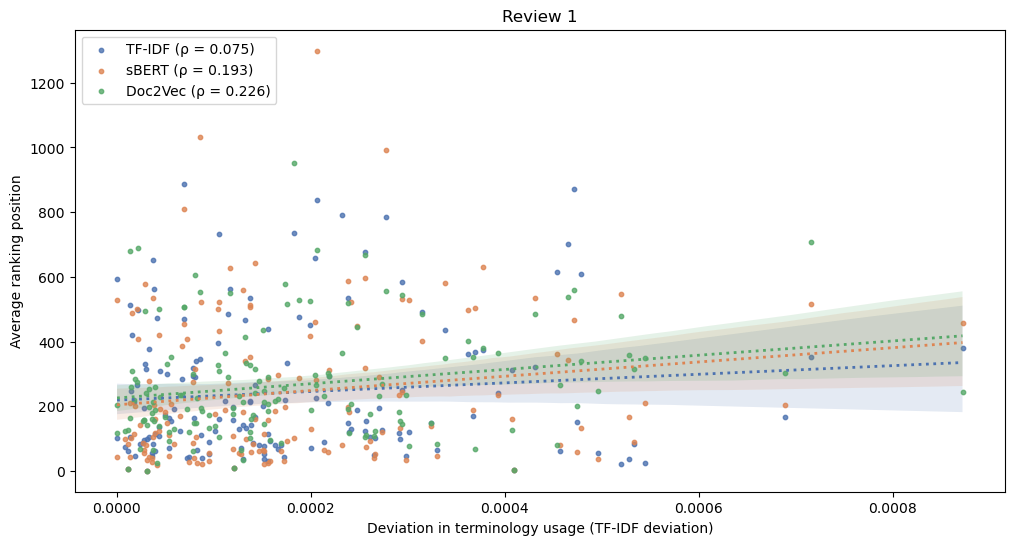

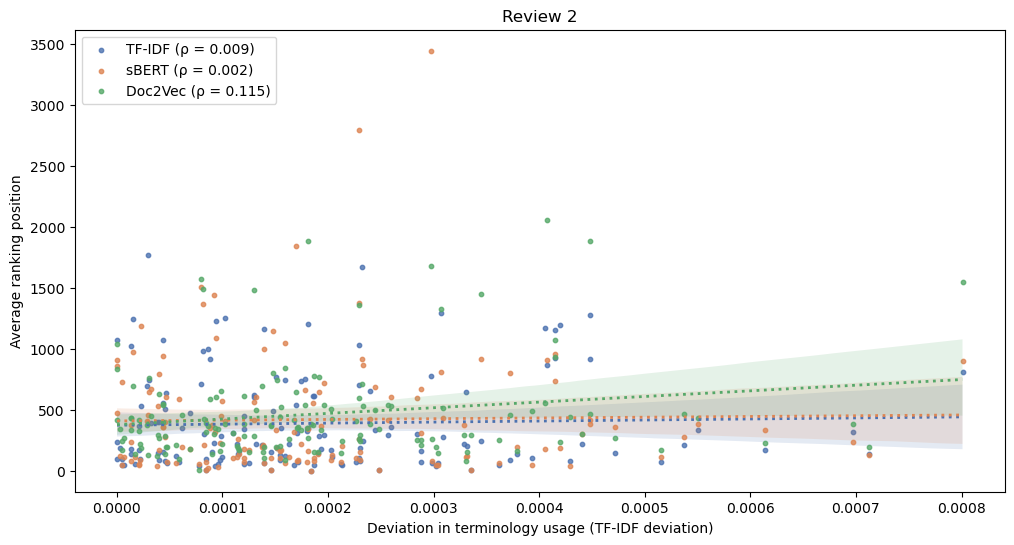

In [22]:
dfs = ['Review 1', 'Review 2'] 

for df_name in dfs: 
    df = review_dic_merged[df_name]
    df_plot1 = df[df['label_ft_included'] == 1].copy()
    
    x_variables = ['tfidf_deviation']
    y_variables = ['TF-IDF', 
                   'sBERT', 
                   'Doc2Vec'
                ]

    
    plt.figure(figsize=(12, 6))
    
    colors = sns.color_palette("deep", len(y_variables))
    
    for i, y_var in enumerate(y_variables):
        x = df_plot1[x_variable]
        y = df_plot1[y_var]

        # Drop NaN values for accurate correlation computation
        df_clean = df_plot1[[x_variables[0], y_var]].dropna()
        spearman_corr, _ = spearmanr(df_clean[x_variables[0]], df_clean[y_var])

        
        sns.regplot(x=x, y=y, scatter=True, 
                    scatter_kws={"s": 10, "color": colors[i]},
                    line_kws={"linewidth": 2, "linestyle": "dotted", "color": colors[i]},
                    label=f"{y_var} (ρ = {spearman_corr:.3f})")  
    
    plt.ylabel("Average ranking position")
    plt.xlabel("Deviation in terminology usage (TF-IDF deviation)")
    plt.legend(loc='upper left', frameon=True)
    plt.title(f'{df_name}')
    plt.show() 